In [1]:
import numpy as np
import pickle
from os import listdir
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd  
import os 
from sklearn.datasets import load_files

# Loading the Data

In [3]:

data_dir =  r'C:\Users\Lenovo\Desktop\TestCNN\herb'
 
data = load_files(data_dir)

# Data Preprocessing and exploring

In [4]:
folders=os.listdir(r"C:\Users\Lenovo\Desktop\TestCNN\herb")
print(folders)

['horapa', 'krapao', 'lemon', 'magrud', 'plu']


In [5]:
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
print('Data files - ',X)
print('Target labels - ',y)

Data files -  ['C:\\Users\\Lenovo\\Desktop\\TestCNN\\herb\\horapa\\aug_0_5121.jpg'
 'C:\\Users\\Lenovo\\Desktop\\TestCNN\\herb\\plu\\aug_0_6349.jpg'
 'C:\\Users\\Lenovo\\Desktop\\TestCNN\\herb\\plu\\aug_0_1180.jpg' ...
 'C:\\Users\\Lenovo\\Desktop\\TestCNN\\herb\\krapao\\aug_0_5798.jpg'
 'C:\\Users\\Lenovo\\Desktop\\TestCNN\\herb\\lemon\\aug_0_4742.jpg'
 'C:\\Users\\Lenovo\\Desktop\\TestCNN\\herb\\lemon\\aug_0_5861.jpg']
Target labels -  [0 4 4 ... 1 2 2]


In [6]:
pyc_file_pos = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))
for pos in pyc_file_pos:
    X = np.delete(X,pos)
    y = np.delete(y,pos)
    
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Number of training files :  5346
Number of training targets :  5346


# Load the images

In [7]:
from keras.preprocessing.image import img_to_array, load_img

def convert_img_to_arr(file_path_list):
    arr = []
    #size=64,64
    img_width, img_height = 150,150
    for file_path in file_path_list:
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        arr.append(img)
        
    return arr
 
X = np.array(convert_img_to_arr(X))
print(X.shape) 
print('First training item : ',X[0])

(5346, 150, 150, 3)
First training item :  [[[138. 195. 176.]
  [114. 166. 177.]
  [120. 173. 204.]
  ...
  [155. 172. 198.]
  [158. 176. 200.]
  [160. 180. 204.]]

 [[171. 224. 198.]
  [113. 162. 166.]
  [114. 162. 185.]
  ...
  [166. 186. 213.]
  [165. 187. 211.]
  [161. 186. 208.]]

 [[173. 222. 192.]
  [129. 175. 173.]
  [112. 157. 176.]
  ...
  [163. 187. 213.]
  [160. 184. 208.]
  [155. 181. 204.]]

 ...

 [[ 74. 156. 134.]
  [ 67. 149. 127.]
  [ 67. 146. 125.]
  ...
  [ 32.  42.  52.]
  [ 24.  34.  44.]
  [ 21.  31.  41.]]

 [[ 67. 150. 130.]
  [ 66. 149. 129.]
  [ 67. 148. 129.]
  ...
  [ 31.  41.  51.]
  [ 30.  40.  50.]
  [ 16.  26.  36.]]

 [[ 61. 146. 125.]
  [ 42. 127. 108.]
  [ 33. 116.  98.]
  ...
  [ 21.  31.  41.]
  [ 30.  40.  50.]
  [ 20.  30.  40.]]]


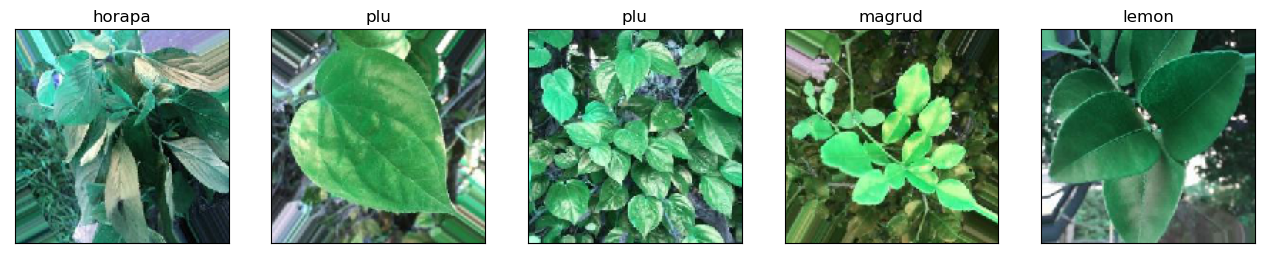

In [8]:


import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [9]:

X = X.astype('float32')/255
no_of_classes = len(np.unique(y))
no_of_classes

5

In [10]:
y

array([0, 4, 4, ..., 1, 2, 2])

# Let's converts a class vector (integers) to binary class matrix

In [11]:
from keras.utils import np_utils
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([1., 0., 0., 0., 0.], dtype=float32)

# Split the data into train, test and valid subsets

In [12]:
from sklearn.model_selection import train_test_split

# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The test Data Shape ', X_test.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The training Data Shape ', X_valid.shape[0])

The test Data Shape  1070
The training Data Shape  535


In [13]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (150, 150, 3)


In [14]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [15]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:], activation='relu', name='Conv2D_1'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_1'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_4'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_2'))
model.add(Dropout(0.25))
    
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_5'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_6'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_3'))

model.add(Flatten())
model.add(Dense(units=512, activation='relu', name='Dense_1'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', name='Dense_2'))
model.add(Dense(units=no_of_classes, activation='softmax', name='Output'))

# Model Summary

In [16]:
# Getting the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 Conv2D_2 (Conv2D)           (None, 148, 148, 32)      9248      
                                                                 
 Maxpool_1 (MaxPooling2D)    (None, 74, 74, 32)        0         
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 Conv2D_4 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 Maxpool_2 (MaxPooling2D)    (None, 36, 36, 64)        0

# Compiling the model

In [17]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [18]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping
 
epochs = 10
batch_size=64
 
train_datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True)
 
test_datagen = ImageDataGenerator()
 
train_generator = train_datagen.flow(
    X_train,y_train,
    batch_size=batch_size)
 
validation_generator = test_datagen.flow(
    X_valid,y_valid,
    batch_size=batch_size)
 
checkpointer = ModelCheckpoint(filepath = "/gdrive/My Drive/PId_Best.h5", save_best_only = True, verbose = 1)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose = 1, factor = 0.5, minlr = 0.00001)
 

start = time.time()
 
history=model.fit_generator(train_generator,
                            epochs=epochs,
                            validation_data = validation_generator,
                            verbose=1,
                            steps_per_epoch=len(X_train) // batch_size,
                            #validation_steps=len(X_valid) //batch_size,
                            callbacks=[checkpointer, learning_rate_reduction])
 
end = time.time()
 
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6416\1486100370.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator,


Epoch 1/10
66/66 [==============================] - ETA: 0s - loss: 1.8280 - accuracy: 0.3146
Epoch 1: val_loss improved from inf to 1.31265, saving model to /gdrive/My Drive\PId_Best.h5
66/66 [==============================] - 227s 3s/step - loss: 1.8280 - accuracy: 0.3146 - val_loss: 1.3126 - val_accuracy: 0.3907 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - ETA: 0s - loss: 1.2551 - accuracy: 0.5161
Epoch 2: val_loss improved from 1.31265 to 0.98479, saving model to /gdrive/My Drive\PId_Best.h5
66/66 [==============================] - 227s 3s/step - loss: 1.2551 - accuracy: 0.5161 - val_loss: 0.9848 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - ETA: 0s - loss: 0.9760 - accuracy: 0.6320
Epoch 3: val_loss improved from 0.98479 to 0.66649, saving model to /gdrive/My Drive\PId_Best.h5
66/66 [==============================] - 224s 3s/step - loss: 0.9760 - accuracy: 0.6320 - val_loss: 0.6665 - val_accuracy: 0.7645 - lr: 0.0010
Ep

In [19]:
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=batch_size, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss))

9/9 - 4s - loss: 0.0757 - accuracy: 0.9794 - 4s/epoch - 452ms/step
Accuracy: 97.94%
Loss: 0.07573874294757843


# Acuuracy and Loss graphs

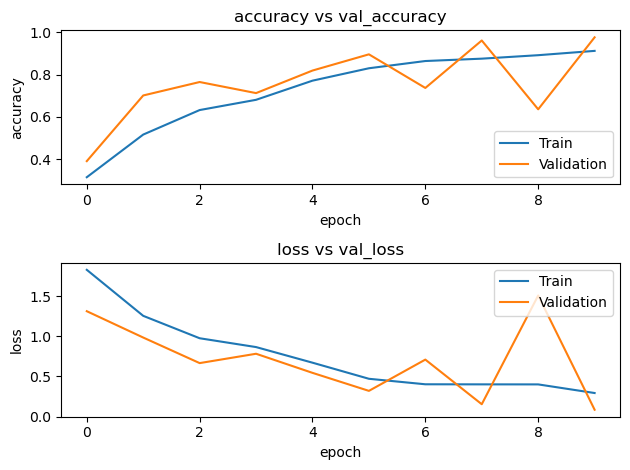

In [20]:
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1)
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
plot(history)

# Prediction

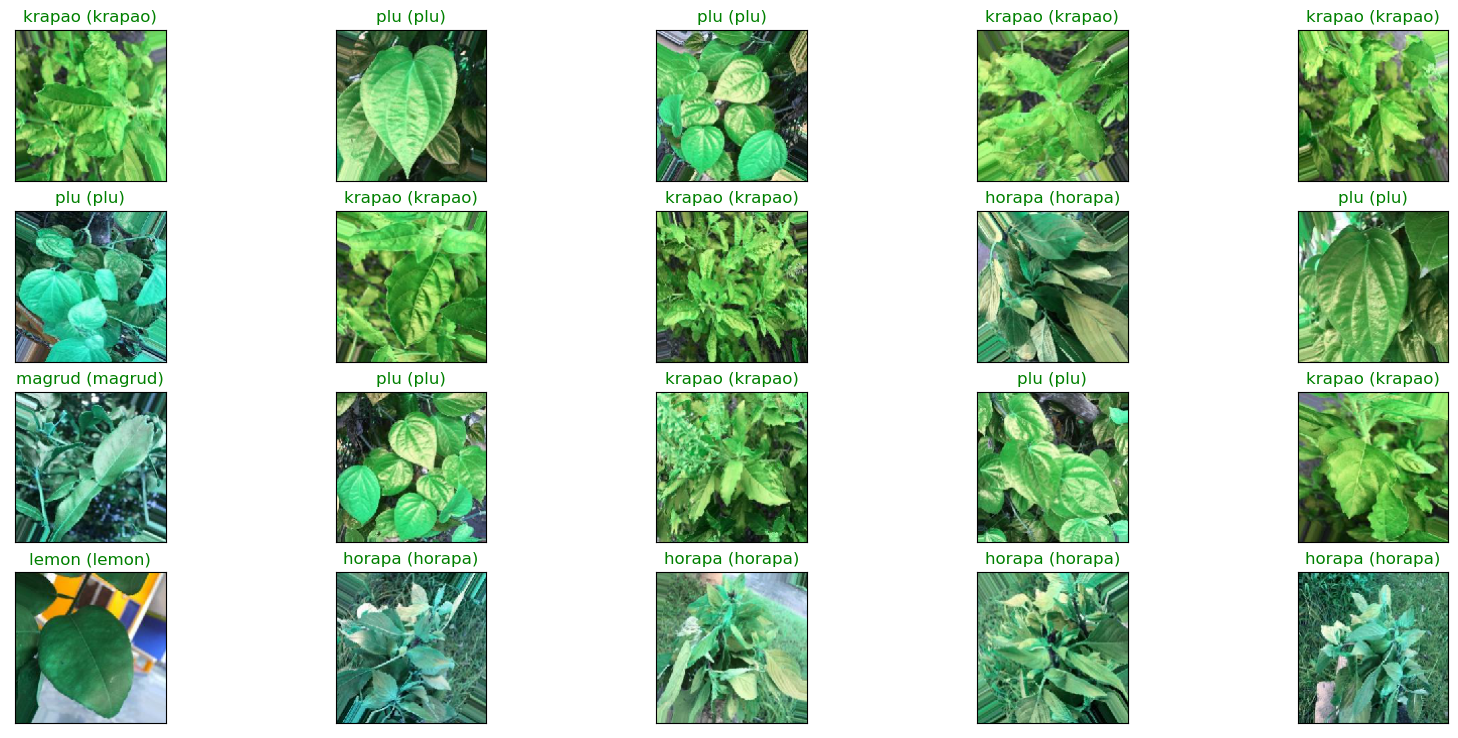

In [23]:
def visualize_pred(y_pred):
    fig = plt.figure(figsize=(20, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

# Confusion matrix

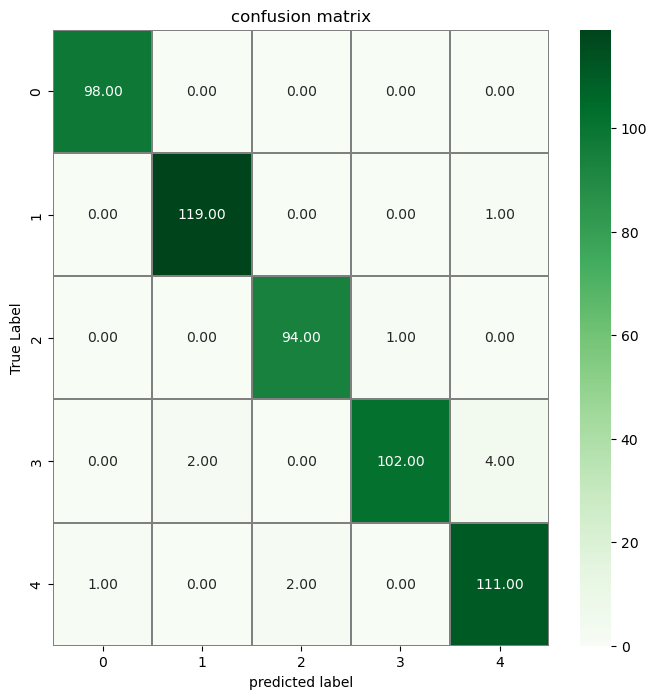

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()